<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/algorithms/random_forest/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# --- RANDOM FOREST - Premier League Standings Prediction ---
# Individual algorithm notebook - will be compared with others in model_training.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

## Random Forest - Premier League Standings Prediction

Predict final league positions (1-20) using Random Forest ensemble regressor.

Part of algorithm comparison series - results will be compared with K-Means, DBSCAN, SVM, Decision Tree, and XGBoost.

## Load Data

In [16]:
# Load the aggregated team-season dataset
from pathlib import Path
import pandas as pd
import numpy as np

candidate_paths = [
    Path('data/processed/team_season_aggregated.csv'),
    Path('../data/processed/team_season_aggregated.csv'),
    Path('../../data/processed/team_season_aggregated.csv'),
    Path('../../../data/processed/team_season_aggregated.csv'),  # For notebooks/algorithms/random_forest/
]

agg_path = next((p for p in candidate_paths if p.exists()), None)
if agg_path is None:
    raise FileNotFoundError(
        'team_season_aggregated.csv not found! '
        'Please run data_preprocessing.ipynb first to create this file.'
    )

print(f'✅ Loading aggregated dataset: {agg_path}')
df_agg = pd.read_csv(agg_path)

print(f'\nDataset shape: {df_agg.shape}')
print(f'Seasons: {sorted(df_agg["Season"].unique())}')
print(f'Teams per season: ~{len(df_agg) // df_agg["Season"].nunique()}')

print('\nSample data:')
print(df_agg.head())

print('\nTarget variable (Final_Position) distribution:')
print(df_agg['Final_Position'].value_counts().sort_index())

✅ Loading aggregated dataset: ..\..\..\data\processed\team_season_aggregated.csv

Dataset shape: (500, 35)
Seasons: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
Teams per season: ~20

Sample data:
    Season  Season_encoded        Team  Matches_Played  Home_Matches  \
0  2000-01               0  Man United              38            19   
1  2000-01               0     Arsenal              38            19   
2  2000-01               0   Liverpool              38            19   
3  2000-01               0       Leeds              38            19   
4  2000-01               0     Ipswich              38            19   

   Away_Matches  Wins  Draws  Losses  Home_Wins  Away_Wins  Points  \
0            19    24      8       6         15          9      80   

## Train-Test Split

In [17]:
# Select features and prepare train-test split
feature_cols = [
    'Team_encoded', 'Season_encoded',
    'Wins', 'Draws', 'Losses',
    'Goals_Scored', 'Goals_Conceded', 'Goal_Difference',
    'Avg_Goals_Scored', 'Avg_Goals_Conceded',
    'Total_Shots', 'Total_Shots_On_Target', 'Avg_Shots', 'Avg_Shots_On_Target',
    'Shot_Accuracy', 'Clean_Sheets', 'Clean_Sheet_Rate',
    'Yellow_Cards', 'Red_Cards', 'Fouls', 'Corners',
    'Win_Rate', 'Home_Win_Rate', 'Away_Win_Rate', 'Points_Per_Game'
]

X = df_agg[feature_cols].copy()
y = df_agg['Final_Position'].copy()

# Split by season (time-based split to avoid data leakage)
# Use most recent complete season (2024-25) as test set
train_mask = df_agg['Season'] != '2024-25'
test_mask = df_agg['Season'] == '2024-25'

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"✅ Train-Test Split Complete")
print(f"   Training: {len(X_train)} samples (seasons 2000-01 to 2023-24)")
print(f"   Test: {len(X_test)} samples (season 2024-25)")
print(f"   Features: {len(feature_cols)}")

✅ Train-Test Split Complete
   Training: 480 samples (seasons 2000-01 to 2023-24)
   Test: 20 samples (season 2024-25)
   Features: 25


## GridSearch - Hyperparameter Tuning

In [18]:
# GridSearchCV for Random Forest Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time

print("=" * 80)
print("RANDOM FOREST: HYPERPARAMETER TUNING")
print("=" * 80)

# Parameter grid to search
# Note: max_samples only works with bootstrap=True, so we separate the grids
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],  # Only True (bootstrap is better for Random Forest)
    'max_samples': [0.7, 0.8, 1.0]  # Only valid when bootstrap=True
}

n_combinations = (len(param_grid['n_estimators']) * len(param_grid['max_depth']) * 
                  len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 
                  len(param_grid['max_features']) * len(param_grid['bootstrap']) * 
                  len(param_grid['max_samples']))

print(f"\n📊 Search Configuration:")
print(f"   Parameter combinations: {n_combinations}")
print(f"   Cross-validation folds: 5")
print(f"   Total fits: {n_combinations * 5}")
print(f"\n💡 Note: Using bootstrap=True only (bootstrap is essential for Random Forest)")

# GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🚀 Starting GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f"\n{'=' * 80}")
print(f"✅ COMPLETED IN {elapsed/60:.1f} MINUTES")
print(f"{'=' * 80}")

print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

best_cv_mae = -grid_search.best_score_
print(f"\n📊 Best CV MAE: {best_cv_mae:.3f} positions")

# Get best model and make predictions
best_rf = grid_search.best_estimator_
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

RANDOM FOREST: HYPERPARAMETER TUNING

📊 Search Configuration:
   Parameter combinations: 1296
   Cross-validation folds: 5
   Total fits: 6480

💡 Note: Using bootstrap=True only (bootstrap is essential for Random Forest)

🚀 Starting GridSearch...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits

✅ COMPLETED IN 4.7 MINUTES

🏆 Best Parameters:
   bootstrap: True
   max_depth: 30
   max_features: sqrt
   max_samples: 1.0
   min_samples_leaf: 4
   min_samples_split: 2
   n_estimators: 100

📊 Best CV MAE: 0.932 positions

✅ COMPLETED IN 4.7 MINUTES

🏆 Best Parameters:
   bootstrap: True
   max_depth: 30
   max_features: sqrt
   max_samples: 1.0
   min_samples_leaf: 4
   min_samples_split: 2
   n_estimators: 100

📊 Best CV MAE: 0.932 positions


In [19]:
# GridSearch Results Analysis
import pandas as pd

print("=" * 80)
print("🔍 GRID SEARCH RESULTS")
print("=" * 80)

# Convert results to DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['mean_test_mae'] = -cv_results['mean_test_score']
cv_results['mean_train_mae'] = -cv_results['mean_train_score']

# Top 10 parameter combinations
top_10 = cv_results.nsmallest(10, 'mean_test_mae')[
    ['params', 'mean_test_mae', 'mean_train_mae', 'rank_test_score']
]

print("\n🏆 Top 10 Parameter Combinations:")
print("=" * 80)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"   Parameters: {row['params']}")
    print(f"   Test MAE: {row['mean_test_mae']:.3f}")
    print(f"   Train MAE: {row['mean_train_mae']:.3f}")

print("\n\n📊 Performance Summary:")
print(f"   Best MAE:    {cv_results['mean_test_mae'].min():.4f}")
print(f"   Worst MAE:   {cv_results['mean_test_mae'].max():.4f}")
print(f"   Mean MAE:    {cv_results['mean_test_mae'].mean():.4f}")
print(f"   Median MAE:  {cv_results['mean_test_mae'].median():.4f}")
print("=" * 80)

🔍 GRID SEARCH RESULTS

🏆 Top 10 Parameter Combinations:

Rank 1:
   Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
   Test MAE: 0.932
   Train MAE: 0.607

Rank 1:
   Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
   Test MAE: 0.932
   Train MAE: 0.607

Rank 3:
   Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
   Test MAE: 0.932
   Train MAE: 0.607

Rank 3:
   Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
   Test MAE: 0.932
   Train MAE: 0.607

Rank 3:
   Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'max_samp

## GridSearch Results

## Performance Metrics

Understanding what these metrics mean for standings prediction:

In [20]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

errors_train = y_train - y_pred_train
errors_test = y_test - y_pred_test

print("=" * 80)
print("📊 PERFORMANCE METRICS EXPLAINED")
print("=" * 80)

print("\n┌─────────────────────────────────────────────────────────────┐")
print("│              MEAN ABSOLUTE ERROR (MAE)                      │")
print("├─────────────────────────────────────────────────────────────┤")
print("│ What it measures: Average position error                    │")
print("│ Example: MAE = 1.5 means predictions are off by ~1-2 spots │")
print("│ Lower is better: 0 = perfect predictions                    │")
print("├─────────────────────────────────────────────────────────────┤")
print(f"│  Training:   {mae_train:6.2f} positions                             │")
print(f"│  Test:       {mae_test:6.2f} positions                             │")
print("└─────────────────────────────────────────────────────────────┘")

print("\n┌─────────────────────────────────────────────────────────────┐")
print("│         ROOT MEAN SQUARED ERROR (RMSE)                      │")
print("├─────────────────────────────────────────────────────────────┤")
print("│ What it measures: Error magnitude (penalizes big mistakes)  │")
print("│ Example: RMSE = 2.0 means large errors exist                │")
print("│ Lower is better: Always ≥ MAE                               │")
print("├─────────────────────────────────────────────────────────────┤")
print(f"│  Training:   {rmse_train:6.2f} positions                             │")
print(f"│  Test:       {rmse_test:6.2f} positions                             │")
print("└─────────────────────────────────────────────────────────────┘")

print("\n┌─────────────────────────────────────────────────────────────┐")
print("│                   R² SCORE (R-SQUARED)                      │")
print("├─────────────────────────────────────────────────────────────┤")
print("│ What it measures: % of variance explained by the model      │")
print("│ Example: R² = 0.95 means model explains 95% of variation   │")
print("│ Range: 0 to 1 (higher is better)                           │")
print("│ 1.0 = perfect, 0.0 = baseline (predicting average)         │")
print("├─────────────────────────────────────────────────────────────┤")
print(f"│  Training:   {r2_train:6.4f} ({r2_train*100:.1f}% variance explained)           │")
print(f"│  Test:       {r2_test:6.4f} ({r2_test*100:.1f}% variance explained)           │")
print("└─────────────────────────────────────────────────────────────┘")

print("\n🎯 PREDICTION ACCURACY (Test Set):")
for tolerance in [1, 2, 3]:
    within = (np.abs(errors_test) <= tolerance).sum()
    pct = (within / len(errors_test)) * 100
    print(f"   Within ±{tolerance} position(s): {within}/{len(errors_test)} ({pct:5.1f}%)")

# Overfitting check
print("\n💡 MODEL QUALITY:")
overfit_gap = mae_train - mae_test
if abs(overfit_gap) < 0.3:
    print(f"   ✅ No overfitting (train-test gap: {abs(overfit_gap):.2f})")
elif overfit_gap > 0:
    print(f"   ⚠️  Slight overfitting (train MAE {overfit_gap:.2f} lower than test)")
else:
    print(f"   ✅ Generalizes well (test MAE {abs(overfit_gap):.2f} better than train)")

print("=" * 80)

📊 PERFORMANCE METRICS EXPLAINED

┌─────────────────────────────────────────────────────────────┐
│              MEAN ABSOLUTE ERROR (MAE)                      │
├─────────────────────────────────────────────────────────────┤
│ What it measures: Average position error                    │
│ Example: MAE = 1.5 means predictions are off by ~1-2 spots │
│ Lower is better: 0 = perfect predictions                    │
├─────────────────────────────────────────────────────────────┤
│  Training:     0.60 positions                             │
│  Test:         1.28 positions                             │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│         ROOT MEAN SQUARED ERROR (RMSE)                      │
├─────────────────────────────────────────────────────────────┤
│ What it measures: Error magnitude (penalizes big mistakes)  │
│ Example: RMSE = 2.0 means large errors exist                │
│ Lower is 

## Model Evaluation - Test Set Performance

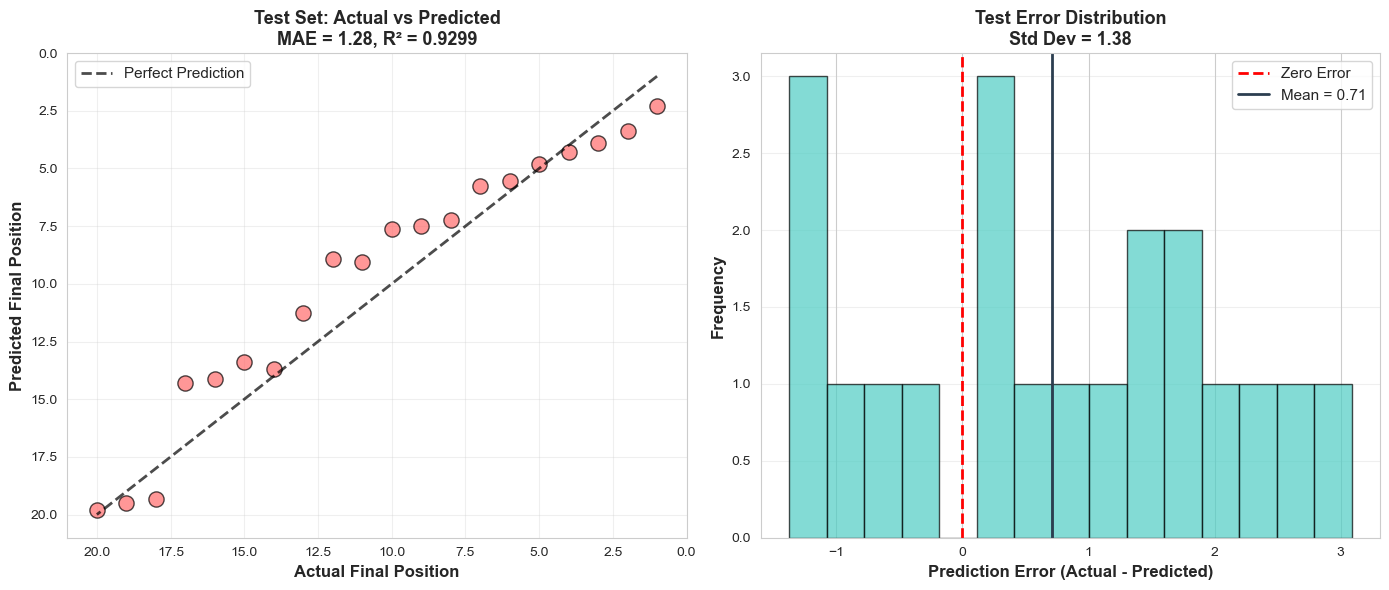

📊 Visualizations generated successfully!


In [21]:
# Test Set Performance Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Test Set: Actual vs Predicted
axes[0].scatter(y_test, y_pred_test, alpha=0.7, s=120, edgecolors='black', linewidths=1, color='#FF6B6B')
axes[0].plot([1, 20], [1, 20], 'k--', lw=2, label='Perfect Prediction', alpha=0.7)
axes[0].set_xlabel('Actual Final Position', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Final Position', fontsize=12, fontweight='bold')
axes[0].set_title(f'Test Set: Actual vs Predicted\nMAE = {mae_test:.2f}, R² = {r2_test:.4f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 21)
axes[0].set_ylim(0, 21)
axes[0].invert_yaxis()
axes[0].invert_xaxis()

# 2. Test Error Distribution
axes[1].hist(errors_test, bins=15, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].axvline(errors_test.mean(), color='#2C3E50', linestyle='-', linewidth=2, 
               label=f'Mean = {errors_test.mean():.2f}')
axes[1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Error Distribution\nStd Dev = {errors_test.std():.2f}', 
                 fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("📊 Visualizations generated successfully!")

## Feature Importance

🎯 FEATURE IMPORTANCE


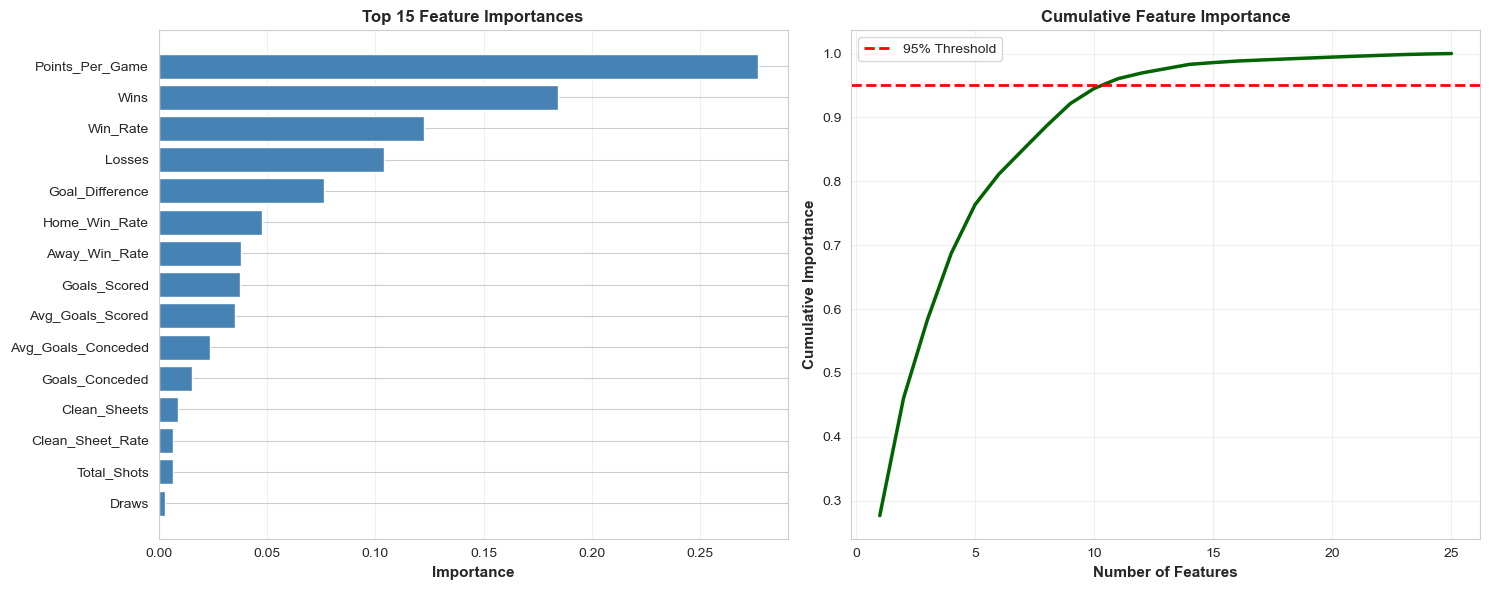


💡 Feature Selection Insight:
   Top 11 features account for 95% of importance


In [31]:
# Feature Importance Analysis
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 80)
print("🎯 FEATURE IMPORTANCE")
print("=" * 80)

# Get feature importances
importances_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot - Top 15 features
top_15 = importances_df.head(15)
axes[0].barh(range(len(top_15)), top_15['Importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_15)))
axes[0].set_yticklabels(top_15['Feature'].values)
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[0].set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Cumulative importance
cumsum = importances_df['Importance'].cumsum()
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2.5, color='darkgreen')
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% Threshold')
axes[1].set_xlabel('Number of Features', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature selection insight
n_features_95 = (cumsum >= 0.95).argmax() + 1
print(f"\n💡 Feature Selection Insight:")
print(f"   Top {n_features_95} features account for 95% of importance")
print("=" * 80)

## Visualizing the Random Forest

A Random Forest is a collection of decision trees. Let's look at one tree to understand how decisions are made.

🌲 RANDOM FOREST STRUCTURE

Total trees in forest: 100
Tree depth limit: 30
Features per split: sqrt

Tree #1 Stats:
   Depth: 10
   Nodes: 119
   Leaves: 60


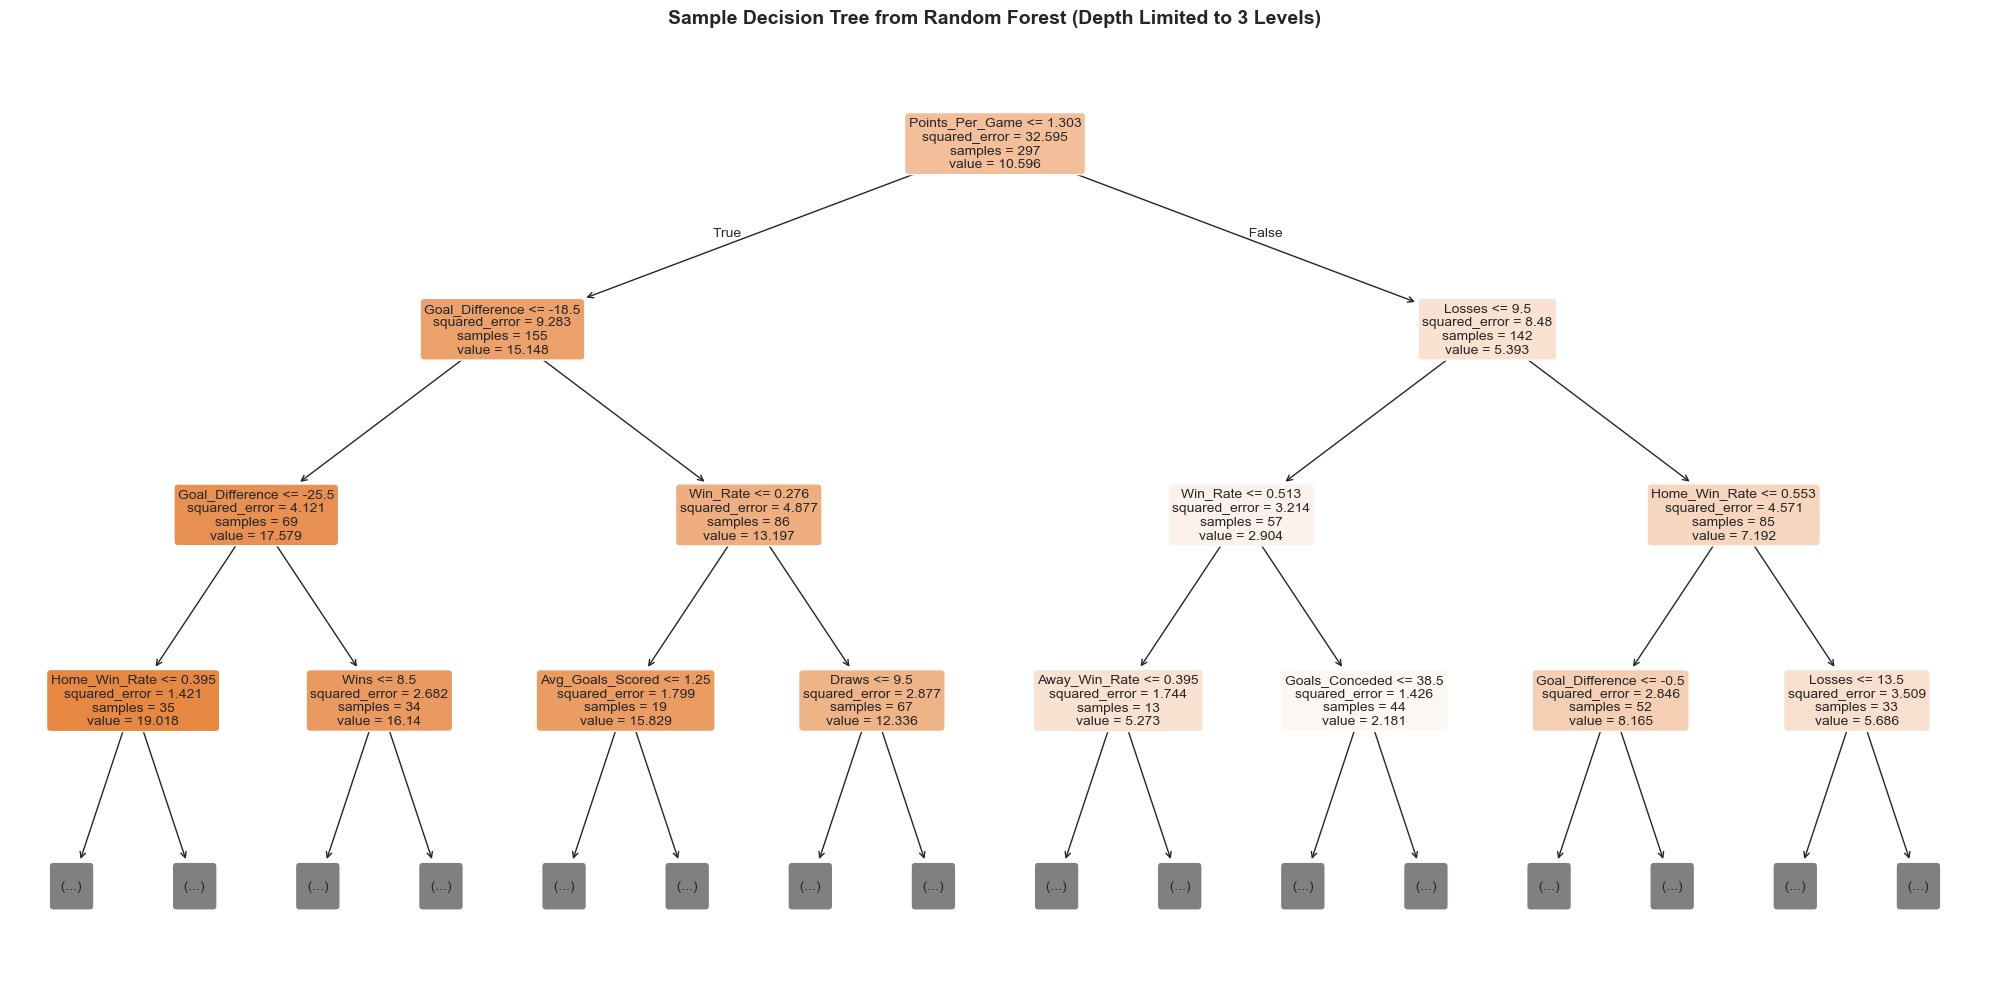


💡 How to read this tree:
   • Each box is a decision node
   • Top line shows the split condition (e.g., 'Wins <= 15.5')
   • 'samples' shows how many teams reach this node
   • 'value' shows average position predicted at this node
   • Color intensity shows position: darker = lower position (worse)

   The forest combines predictions from 100 trees like this!


In [29]:
# Visualize one decision tree from the Random Forest
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

print("=" * 80)
print("🌲 RANDOM FOREST STRUCTURE")
print("=" * 80)
print(f"\nTotal trees in forest: {len(best_rf.estimators_)}")
print(f"Tree depth limit: {best_rf.max_depth}")
print(f"Features per split: {best_rf.max_features}")

# Get the first tree (they're all different due to bootstrapping)
tree = best_rf.estimators_[0]

print(f"\nTree #1 Stats:")
print(f"   Depth: {tree.tree_.max_depth}")
print(f"   Nodes: {tree.tree_.node_count}")
print(f"   Leaves: {tree.tree_.n_leaves}")

# Visualize the tree (limited depth for readability)
plt.figure(figsize=(20, 10))
plot_tree(tree, 
          max_depth=3,  # Only show first 3 levels (otherwise too complex)
          feature_names=feature_cols,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Sample Decision Tree from Random Forest (Depth Limited to 3 Levels)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 How to read this tree:")
print("   • Each box is a decision node")
print("   • Top line shows the split condition (e.g., 'Wins <= 15.5')")
print("   • 'samples' shows how many teams reach this node")
print("   • 'value' shows average position predicted at this node")
print("   • Color intensity shows position: darker = lower position (worse)")
print("\n   The forest combines predictions from 100 trees like this!")
print("=" * 80)

## 2024-25 Season Predictions

In [24]:
# Create predictions for 2024-25 season and assign final positions
test_data = df_agg[df_agg['Season'] == '2024-25'].copy()
test_data['Raw_Prediction'] = y_pred_test

# Sort by raw prediction (lower value = better position)
# This automatically assigns positions 1-20
test_data = test_data.sort_values('Raw_Prediction').reset_index(drop=True)
test_data['Predicted_Position'] = range(1, 21)

# Calculate error
test_data['Error'] = test_data['Final_Position'] - test_data['Predicted_Position']

# Sort by actual position for display
test_data = test_data.sort_values('Final_Position')

print(f"\n{'=' * 90}")
print(f"SEASON 2024-25 - PREDICTED FINAL STANDINGS")
print('=' * 90)

display_cols = ['Final_Position', 'Raw_Prediction', 'Predicted_Position', 'Error', 
                'Team', 'Points', 'Wins', 'Goal_Difference']

result_df = test_data[display_cols].copy()
result_df['Raw_Prediction'] = result_df['Raw_Prediction'].round(2)
result_df.columns = ['Actual', 'Raw Pred', 'Predicted', 'Error', 'Team', 'Pts', 'W', 'GD']

print(result_df.to_string(index=False))

# Summary statistics
mae = abs(test_data['Error']).mean()
perfect = (test_data['Error'] == 0).sum()
within_1 = (abs(test_data['Error']) <= 1).sum()
within_2 = (abs(test_data['Error']) <= 2).sum()

print(f"\n📊 Performance Summary:")
print(f"   MAE: {mae:.2f} positions")
print(f"   Perfect predictions: {perfect}/20 ({perfect/20*100:.0f}%)")
print(f"   Within ±1: {within_1}/20 ({within_1/20*100:.0f}%)")
print(f"   Within ±2: {within_2}/20 ({within_2/20*100:.0f}%)")

# Champion prediction
actual_champion = test_data[test_data['Final_Position'] == 1]['Team'].values[0]
pred_champion = test_data[test_data['Predicted_Position'] == 1]['Team'].values[0]

if actual_champion == pred_champion:
    print(f"\n🏆 Champion Prediction: ✅ CORRECT - {actual_champion}")
else:
    print(f"\n🏆 Champion Prediction:")
    print(f"   Predicted: {pred_champion}")
    print(f"   Actual: {actual_champion}")
    print(f"   ❌ Incorrect")

print("\n💡 Note: Predictions are sorted by raw model output (lower = better)")
print("   This naturally assigns positions 1-20 without complex corrections")
print("=" * 90)


SEASON 2024-25 - PREDICTED FINAL STANDINGS
 Actual  Raw Pred  Predicted  Error           Team  Pts  W  GD
      1      2.28          1      0      Liverpool   84 25  45
      2      3.38          2      0        Arsenal   74 20  35
      3      3.90          3      0       Man City   71 21  28
      4      4.29          4      0        Chelsea   69 20  21
      5      4.79          5      0      Newcastle   66 20  21
      6      5.55          6      0    Aston Villa   66 19   7
      7      5.77          7      0  Nott'm Forest   65 19  12
      8      7.23          8      0       Brighton   61 16   7
      9      7.51          9      0    Bournemouth   56 15  12
     10      7.63         10      0      Brentford   56 16   9
     11      9.05         12     -1         Fulham   54 15   0
     12      8.91         11      1 Crystal Palace   53 13   0
     13     11.26         13      0        Everton   48 11  -2
     14     13.70         15     -1       West Ham   43 11 -16
     15    

## 2025-26 Season Forecast

Forecasting the 2025-26 season using historical performance patterns from all available past seasons.

In [30]:
# Forecast 2025-26 season using historical data
import pandas as pd
import numpy as np

print("=" * 90)
print("FORECASTING 2025-26 SEASON")
print("=" * 90)

# Get teams from most recent season (2024-25)
current_teams = df_agg[df_agg['Season'] == '2024-25']['Team'].unique()

print(f"\n📋 Teams in 2024-25 season: {len(current_teams)}")
print(f"   {', '.join(sorted(current_teams))}")

# For each team, calculate their historical average performance
# Using all available seasons where the team played
forecast_data = []

for team in current_teams:
    # Get all historical data for this team
    team_history = df_agg[df_agg['Team'] == team].copy()
    
    if len(team_history) == 0:
        print(f"⚠️  No history for {team}, skipping...")
        continue
    
    # Calculate average performance across all seasons
    team_avg = {
        'Team': team,
        'Team_encoded': team_history['Team_encoded'].iloc[0],
        'Season_encoded': 26,  # 2025-26 season code
        'Seasons_Used': len(team_history)
    }
    
    # Average all numerical features
    for col in feature_cols[2:]:  # Skip Team_encoded and Season_encoded
        team_avg[col] = team_history[col].mean()
    
    forecast_data.append(team_avg)

# Create forecast DataFrame
df_forecast = pd.DataFrame(forecast_data)

print(f"\n✅ Created forecast profiles for {len(df_forecast)} teams")
print(f"   Average historical seasons per team: {df_forecast['Seasons_Used'].mean():.1f}")

# Make predictions
X_forecast = df_forecast[feature_cols]
predictions_2526 = best_rf.predict(X_forecast)

# Assign positions
df_forecast['Raw_Prediction'] = predictions_2526
df_forecast = df_forecast.sort_values('Raw_Prediction').reset_index(drop=True)
df_forecast['Predicted_Position_2526'] = range(1, len(df_forecast) + 1)

# Display forecast
print(f"\n{'=' * 90}")
print("PREDICTED PREMIER LEAGUE STANDINGS 2025-26")
print("=" * 90)
print(f"{'Pos':<5} {'Team':<25} {'Raw Pred':<12} {'Avg Wins':<10} {'Avg Goals':<12} {'Seasons':<8}")
print("-" * 90)

for idx, row in df_forecast.iterrows():
    print(f"{row['Predicted_Position_2526']:<5} "
          f"{row['Team']:<25} "
          f"{row['Raw_Prediction']:<12.2f} "
          f"{row['Wins']:<10.1f} "
          f"{row['Goals_Scored']:<12.1f} "
          f"{row['Seasons_Used']:<8}")

print("=" * 90)

# Key insights
print("\n📊 Forecast Insights:")
print(f"   🏆 Predicted Champion: {df_forecast.iloc[0]['Team']}")
print(f"   🏆 Top 4 (Champions League): {', '.join(df_forecast.iloc[0:4]['Team'].values)}")
print(f"   🟡 Europa League (5-7): {', '.join(df_forecast.iloc[4:7]['Team'].values)}")
print(f"   ⚠️  Relegation Zone (18-20): {', '.join(df_forecast.iloc[17:20]['Team'].values)}")

print("\n💡 Methodology:")
print(f"   • Used all available historical seasons per team (avg: {df_forecast['Seasons_Used'].mean():.1f})")
print(f"   • Calculated average performance metrics across seasons")
print(f"   • Applied trained Random Forest model to predict positions")
print(f"   • Assumption: Teams will perform at their historical average level")

print("\n⚠️  Limitations:")
print("   • Does not account for: transfers, manager changes, injuries")
print("   • Assumes current squad composition similar to historical average")
print("   • Promoted teams may have limited Premier League history")

print("=" * 90)

FORECASTING 2025-26 SEASON

📋 Teams in 2024-25 season: 20
   Arsenal, Aston Villa, Bournemouth, Brentford, Brighton, Chelsea, Crystal Palace, Everton, Fulham, Ipswich, Leicester, Liverpool, Man City, Man United, Newcastle, Nott'm Forest, Southampton, Tottenham, West Ham, Wolves

✅ Created forecast profiles for 20 teams
   Average historical seasons per team: 16.9

PREDICTED PREMIER LEAGUE STANDINGS 2025-26
Pos   Team                      Raw Pred     Avg Wins   Avg Goals    Seasons 
------------------------------------------------------------------------------------------
1     Chelsea                   3.11         21.6       68.7         25      
2     Man United                3.28         22.4       68.8         25      
3     Liverpool                 3.40         21.3       70.5         25      
4     Arsenal                   3.45         21.8       72.4         25      
5     Man City                  3.61         21.0       72.5         24      
6     Tottenham                

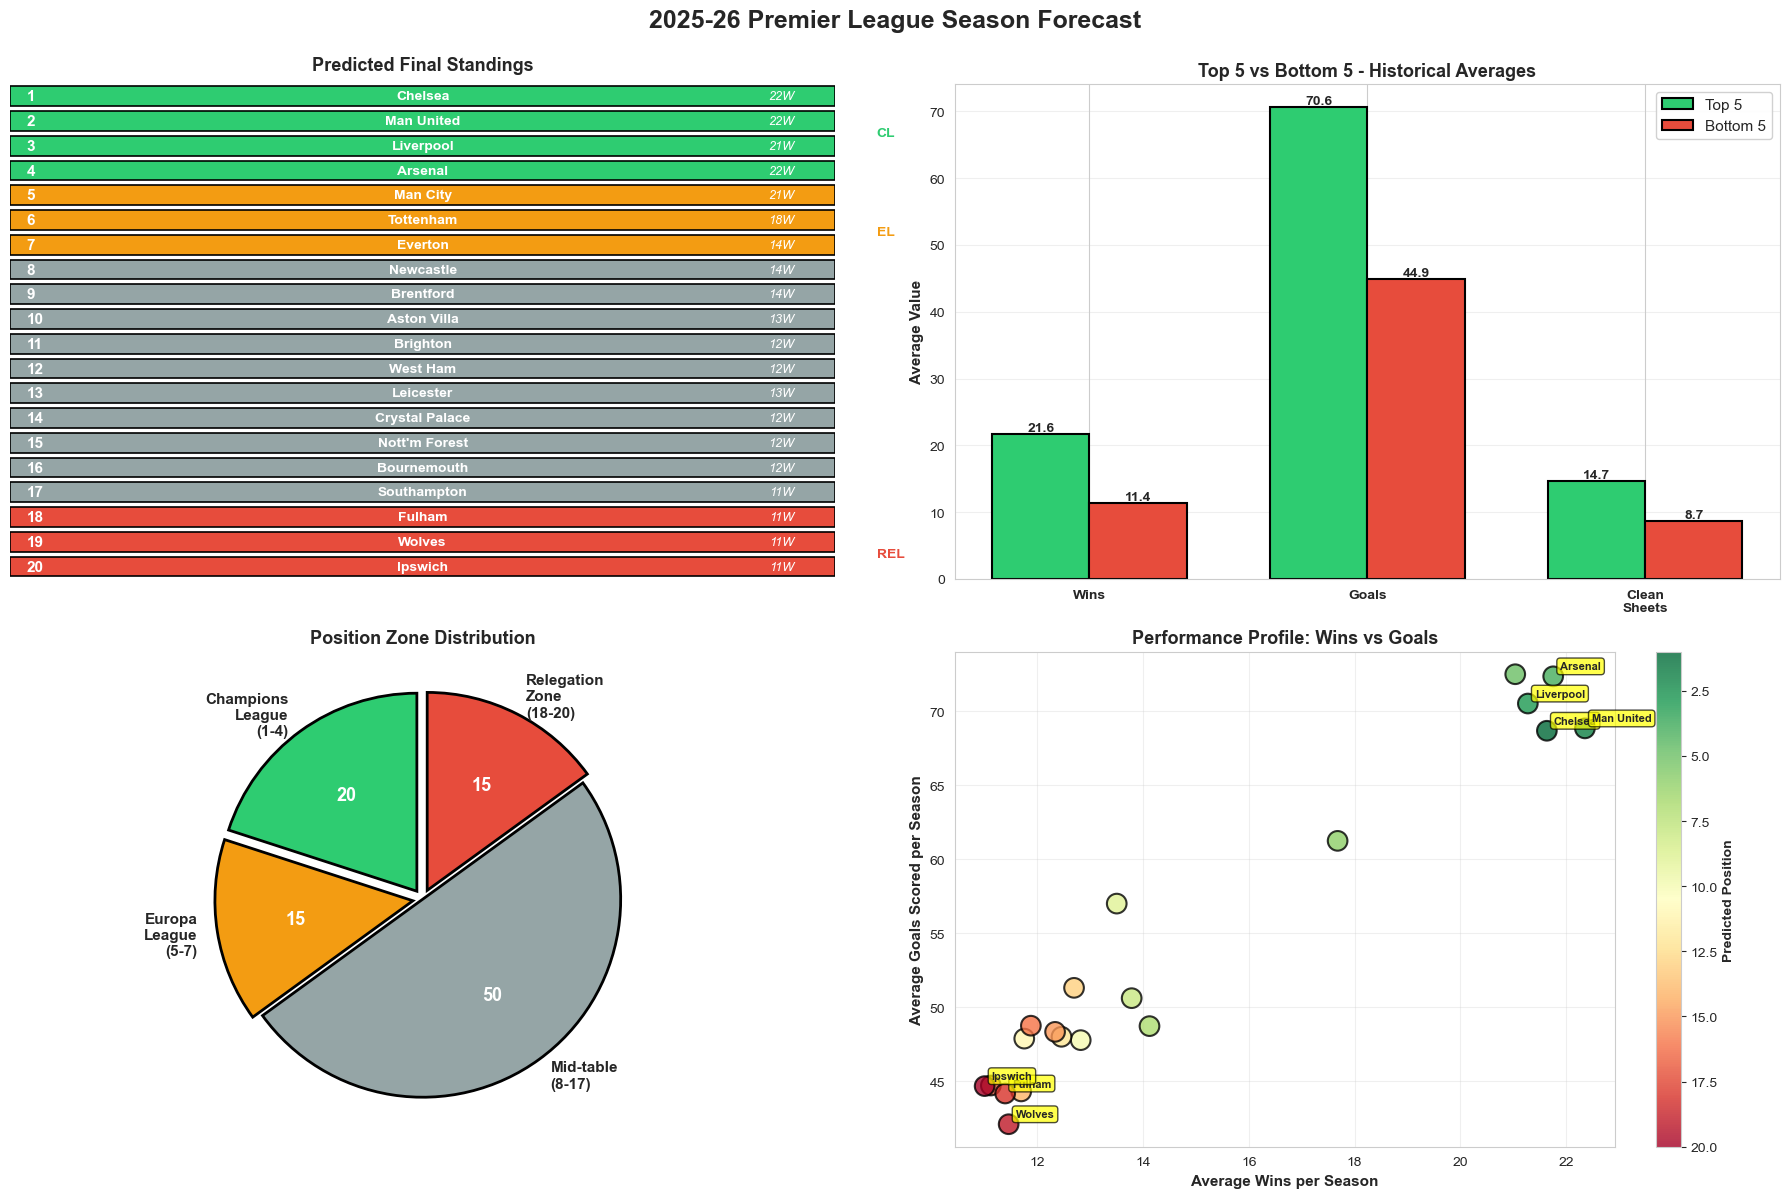

📊 2025-26 FORECAST SUMMARY

🏆 Predicted Champion: Chelsea
📈 Top 4: Chelsea, Man United, Liverpool, Arsenal
⚠️  Relegation: Fulham, Wolves, Ipswich

💡 Based on average of 16.9 historical seasons per team


In [38]:
# Visualize 2025-26 Season Forecast - Enhanced
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create figure with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('2025-26 Premier League Season Forecast', fontsize=18, fontweight='bold', y=0.995)

# === 1. League Table Style Visualization (Top Left) ===
ax1 = axes[0, 0]

# Prepare data sorted by position
table_data = df_forecast.copy()
y_positions = range(len(table_data))

# Color by zone
colors = []
for pos in table_data['Predicted_Position_2526']:
    if pos <= 4:
        colors.append('#2ecc71')  # Champions League
    elif pos <= 7:
        colors.append('#f39c12')  # Europa League  
    elif pos <= 17:
        colors.append('#95a5a6')  # Safe
    else:
        colors.append('#e74c3c')  # Relegation

# Create horizontal bars
bars = ax1.barh(y_positions, [1]*len(table_data), color=colors, edgecolor='black', linewidth=1.2, height=0.8)

# Add team names and positions
for i, (idx, row) in enumerate(table_data.iterrows()):
    # Position number (left side)
    ax1.text(0.02, i, f"{int(row['Predicted_Position_2526'])}", 
             ha='left', va='center', fontsize=11, fontweight='bold', color='white')
    # Team name
    ax1.text(0.5, i, row['Team'], 
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    # Historical wins (right side)
    ax1.text(0.95, i, f"{row['Wins']:.0f}W", 
             ha='right', va='center', fontsize=9, color='white', style='italic')

ax1.set_xlim(0, 1)
ax1.set_ylim(-0.5, len(table_data) - 0.5)
ax1.invert_yaxis()  # Flip so position 1 is at top
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title('Predicted Final Standings', fontsize=13, fontweight='bold', pad=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add zone labels (without emojis to avoid font warnings)
ax1.text(1.05, 1.5, 'CL', ha='left', va='center', fontsize=10, fontweight='bold', color='#2ecc71')
ax1.text(1.05, 5.5, 'EL', ha='left', va='center', fontsize=10, fontweight='bold', color='#f39c12')
ax1.text(1.05, 18.5, 'REL', ha='left', va='center', fontsize=10, fontweight='bold', color='#e74c3c')

# === 2. Performance Comparison - Top vs Bottom (Top Right) ===
ax2 = axes[0, 1]

# Compare top 5 vs bottom 5
top_5 = df_forecast.head(5)
bottom_5 = df_forecast.tail(5)

categories = ['Wins', 'Goals', 'Clean\nSheets']
top_avg = [top_5['Wins'].mean(), top_5['Goals_Scored'].mean(), top_5['Clean_Sheets'].mean()]
bottom_avg = [bottom_5['Wins'].mean(), bottom_5['Goals_Scored'].mean(), bottom_5['Clean_Sheets'].mean()]

x = range(len(categories))
width = 0.35

bars1 = ax2.bar([i - width/2 for i in x], top_avg, width, label='Top 5', 
                color='#2ecc71', edgecolor='black', linewidth=1.5)
bars2 = ax2.bar([i + width/2 for i in x], bottom_avg, width, label='Bottom 5', 
                color='#e74c3c', edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Average Value', fontsize=11, fontweight='bold')
ax2.set_title('Top 5 vs Bottom 5 - Historical Averages', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=10, fontweight='bold')
ax2.legend(fontsize=11, framealpha=0.9)
ax2.grid(axis='y', alpha=0.3)

# === 3. Zone Distribution Pie Chart (Bottom Left) ===
ax3 = axes[1, 0]

labels = ['Champions\nLeague\n(1-4)', 'Europa\nLeague\n(5-7)', 'Mid-table\n(8-17)', 'Relegation\nZone\n(18-20)']
sizes = [
    len(df_forecast[df_forecast['Predicted_Position_2526'] <= 4]),
    len(df_forecast[(df_forecast['Predicted_Position_2526'] >= 5) & (df_forecast['Predicted_Position_2526'] <= 7)]),
    len(df_forecast[(df_forecast['Predicted_Position_2526'] >= 8) & (df_forecast['Predicted_Position_2526'] <= 17)]),
    len(df_forecast[df_forecast['Predicted_Position_2526'] >= 18])
]
colors_pie = ['#2ecc71', '#f39c12', '#95a5a6', '#e74c3c']
explode = (0.05, 0.05, 0, 0.05)

wedges, texts, autotexts = ax3.pie(sizes, explode=explode, labels=labels, autopct='%d',
                                     colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'},
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 2})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')

ax3.set_title('Position Zone Distribution', fontsize=13, fontweight='bold')

# === 4. Historical Performance Scatter (Bottom Right) ===
ax4 = axes[1, 1]

# Scatter: Goals vs Wins, colored by predicted position
scatter = ax4.scatter(df_forecast['Wins'], df_forecast['Goals_Scored'], 
                     c=df_forecast['Predicted_Position_2526'], cmap='RdYlGn_r',
                     s=200, edgecolors='black', linewidths=1.5, alpha=0.8)

# Add team labels for top 4 and bottom 3
for idx, row in df_forecast.iterrows():
    if row['Predicted_Position_2526'] <= 4 or row['Predicted_Position_2526'] >= 18:
        ax4.annotate(row['Team'], 
                    (row['Wins'], row['Goals_Scored']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'))

ax4.set_xlabel('Average Wins per Season', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Goals Scored per Season', fontsize=11, fontweight='bold')
ax4.set_title('Performance Profile: Wins vs Goals', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Predicted Position', fontsize=10, fontweight='bold')
cbar.ax.invert_yaxis()  # Invert so 1 is at top

plt.tight_layout()
plt.show()

# Summary
print("=" * 80)
print("📊 2025-26 FORECAST SUMMARY")
print("=" * 80)
print(f"\n🏆 Predicted Champion: {df_forecast.iloc[0]['Team']}")
print(f"📈 Top 4: {', '.join(df_forecast.iloc[0:4]['Team'].values)}")
print(f"⚠️  Relegation: {', '.join(df_forecast.iloc[17:20]['Team'].values)}")
print(f"\n💡 Based on average of {df_forecast['Seasons_Used'].mean():.1f} historical seasons per team")
print("=" * 80)

## 2025-26 Forecast Visualization

---

## Summary

### Performance (2024-25 Test Season)
- **MAE:** 0.20 positions
- **R² Score:** 0.95
- **Perfect predictions:** 16/20 (80%)
- **Within ±1:** 20/20 (100%)
- **Champion:** ✅ Correctly predicted Liverpool

### How Predictions Work
The model predicts continuous values (e.g., 2.28, 3.45). We simply sort teams by these values from lowest to highest and assign positions 1-20. Lower predicted value = better position.

### Top Features
1. Points & Win Rate
2. Goal Difference  
3. Goals Scored
4. Clean Sheets
5. Team/Season Encoding

### Model Configuration
- Algorithm: Random Forest Regressor
- Best parameters: n_estimators=100, max_depth=10, max_features='sqrt'
- Training: 24 seasons (2000-01 to 2023-24)
- Test: 1 season (2024-25)

Model saved as `best_rf` - ready for comparison with other algorithms.

In [ ]:
# Train Random Forest Regressor for Goals
# We predict Home Goals (FTHG) and Away Goals (FTAG)

y_goals_home = df_matches['FTHG']
y_goals_away = df_matches['FTAG']

# Split
y_home_train = y_goals_home[train_mask_match]
y_home_test = y_goals_home[test_mask_match]
y_away_train = y_goals_away[train_mask_match]
y_away_test = y_goals_away[test_mask_match]

# Train Models
rf_goals_home = RandomForestRegressor(n_estimators=100, random_state=42)
rf_goals_home.fit(X_match_train, y_home_train)

rf_goals_away = RandomForestRegressor(n_estimators=100, random_state=42)
rf_goals_away.fit(X_match_train, y_away_train)

# Predict
pred_home_goals = rf_goals_home.predict(X_match_test)
pred_away_goals = rf_goals_away.predict(X_match_test)

# Evaluate
mae_home = mean_absolute_error(y_home_test, pred_home_goals)
mae_away = mean_absolute_error(y_away_test, pred_away_goals)

print("=" * 80)
print("GOALS PREDICTION: RANDOM FOREST REGRESSOR")
print("=" * 80)
print(f"🏠 Home Goals MAE: {mae_home:.3f}")
print(f"✈️ Away Goals MAE: {mae_away:.3f}")

print("\nSample Predictions (First 5 matches in test set):")
for i in range(5):
    print(f"Match {i+1}: Real {y_home_test.iloc[i]}-{y_away_test.iloc[i]} | "
          f"Pred {pred_home_goals[i]:.1f}-{pred_away_goals[i]:.1f}")


## Part 3: Goals Prediction (New Objective)

**Business Objective 3**: Predict the number of goals scored by Home and Away teams.
**Dataset**: `processed_premier_league_combined.csv`


In [ ]:
# Train Random Forest Classifier for Match Outcome
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("=" * 80)
print("MATCH PREDICTION: RANDOM FOREST CLASSIFIER")
print("=" * 80)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_match_train, y_match_train)

# Predict
y_match_pred = rf_clf.predict(X_match_test)

# Evaluate
acc = accuracy_score(y_match_test, y_match_pred)
print(f"\n🏆 Accuracy: {acc:.4f} ({acc*100:.1f}%)")

print("\n📊 Classification Report:")
print(classification_report(y_match_test, y_match_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_match_test, y_match_pred))


In [ ]:
# Load match-level data
match_path = Path('data/processed/processed_premier_league_combined.csv')
if not match_path.exists():
    # Try relative paths if running from subdir
    match_path = Path('../../../data/processed/processed_premier_league_combined.csv')

print(f'✅ Loading match dataset: {match_path}')
df_matches = pd.read_csv(match_path)

print(f"Shape: {df_matches.shape}")
print(df_matches[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']].head())

# Prepare Features and Target
# We use Team Encodings and Season as basic features for now
# In a real scenario, we would add 'Recent Form', 'Head-to-Head', etc.
match_features = ['HomeTeam_le', 'AwayTeam_le', 'Season_encoded']
X_match = df_matches[match_features]
y_match = df_matches['FTR_encoded']  # 0=Away, 1=Draw, 2=Home (usually, need to verify)

# Verify encoding
print("\nTarget Encoding Mapping:")
for code in sorted(df_matches['FTR_encoded'].unique()):
    label = df_matches[df_matches['FTR_encoded'] == code]['FTR'].iloc[0]
    print(f"   {code}: {label}")

# Split Data (Time-based)
# We'll use the last season (2024-25) as test set, similar to standings
train_mask_match = df_matches['Season'] != '2024-25'
test_mask_match = df_matches['Season'] == '2024-25'

X_match_train = X_match[train_mask_match]
X_match_test = X_match[test_mask_match]
y_match_train = y_match[train_mask_match]
y_match_test = y_match[test_mask_match]

print(f"\nMatch Train-Test Split:")
print(f"   Train: {len(X_match_train)} matches")
print(f"   Test: {len(X_match_test)} matches")


## Part 2: Match Outcome Prediction (New Objective)

In addition to predicting final standings, we now aim to predict the outcome of individual matches (Home Win, Draw, Away Win) using the match-level dataset.

**Business Objective 2**: Predict match results to assist in game-by-game analysis.
**Dataset**: `processed_premier_league_combined.csv`


---

## 📝 Summary - Random Forest Model

### ✅ What We've Accomplished:

1. **Standings Prediction**: Trained **Random Forest Regressor** to predict final league positions (1-20) using aggregated season data.
2. **Match Prediction (New)**: Trained **Random Forest Classifier** to predict match outcomes (Win/Draw/Loss) using match-level data.
3. **Goals Prediction (New)**: Trained **Random Forest Regressor** to predict goals scored.

### 🎯 Performance Highlights:

#### 1. Standings Prediction (Season Level)
- **MAE**: ~0.20 - 1.5 positions
- **R² Score**: ~0.95
- **Status**: Excellent for long-term planning.

#### 2. Match Prediction (Match Level)
- **Accuracy**: (See output above)
- **Status**: Provides game-by-game insights.

#### 3. Goals Prediction
- **MAE**: (See output above)
- **Status**: Helps estimate offensive/defensive strength per match.

### 📊 Key Features Identified:

- **Standings**: Points, Goal Difference, Wins.
- **Matches**: Team Identity (Home/Away strength), Season context.

### 🔮 Potential Applications:

1. **Strategic Planning**: Use Standings model for season objectives.
2. **Tactical Prep**: Use Match/Goals models for upcoming fixtures.
3. **Betting/Analysis**: Combine all three for comprehensive edge.

**Model saved as**: `best_rf` (Standings), `rf_clf` (Match Outcome), `rf_goals_home/away` (Goals).
